In [1]:
import numpy as np
import matplotlib.pyplot as plt

from MDAnalysis import Universe

### Helper function

In [2]:
def get_correlation_matrix(coords, ref_coords):
    R = np.zeros((3,3), dtype=np.float64)

    for i in range(3):
        for j in range(3):
            R[i,j] = np.dot(coords[:,j], ref_coords[:,i])

    return R

In [3]:
def get_overlap_matrix(R):
    S = np.zeros((4,4), dtype=np.float64)

    S[0,0] = R[0,0] + R[1,1] + R[2,2]
    S[1,0] = R[1,2] - R[2,1]
    S[2,0] = R[2,0] - R[0,2]
    S[3,0] = R[0,1] - R[1,0]

    S[0,1] = S[1, 0]
    S[1,1] = R[0,0] - R[1,1] - R[2,2]
    S[2,1] = R[0,1] + R[1,0]
    S[3,1] = R[0,2] + R[2,0]

    S[0,2] = S[2,0]
    S[1,2] = S[2,1]
    S[2,2] = -R[0,0] + R[1,1] - R[2,2]
    S[3,2] = R[1,2] + R[2,1]

    S[0,3] = S[3,0]
    S[1,3] = S[3,1]
    S[2,3] = S[3,2]
    S[3,3] = -R[0,0] - R[1,1] + R[2,2]

    return S

In [4]:
def minimal_image_quaternion(quat, ref_quat):
    if np.dot(quat, ref_quat) >= 0:
        return quat
    else:
        quat *= -1.0
        return quat

In [5]:
def quat_to_euler(q, degrees=False):
    phi = np.arctan2(2*(q[0]*q[1] + q[2]*q[3]), 1-2*(q[1]**2 + q[2]**2))
    theta = np.arcsin(2*(q[0]*q[2] - q[3]*q[1])) + np.pi/2
    psi = np.arctan2(2*(q[0]*q[3] + q[1]*q[2]), 1-2*(q[2]**2 + q[3]**2))
    
    if degrees:
        phi *= 180/np.pi
        theta *= 180/np.pi
        psi *= 180/np.pi
    
    return phi, theta, psi

### Reference structure

In [6]:
u_ref = Universe("PRO-sol.prmtop", "atoms.pdb")
propofol_ref = u_ref.select_atoms("resname PRO")
ref_coords = propofol_ref.positions
ref_coords -= np.mean(ref_coords, axis=0)

### Load trajectory

In [7]:
u = Universe("PRO-sol.prmtop", ["out_eq01.dcd"])
propofol = u.select_atoms("resname PRO")

In [8]:
ref_quat = np.array([1.0, 0.0, 0.0, 0.0])

In [9]:
orientation_colvar = []
euler_angles = []

for ts in u.trajectory:
    # Centering molecule
    coords = propofol.positions
    coords -= np.mean(coords, axis=0)

    # Calculate matrices
    R = get_correlation_matrix(ref_coords, coords)
    S = get_overlap_matrix(R)

    # Eigen decomposition
    e_val, e_vec = np.linalg.eig(S)

    # Minimal-image convention
    quat = e_vec[:,0]
    quat = minimal_image_quaternion(quat, ref_quat)

    # Add results
    orientation_colvar.append(quat)
    euler_angles.append(quat_to_euler(quat))

euler_angles = np.array(euler_angles)

### Euler Angles

Text(0.5, 1.0, '$\\Psi$')

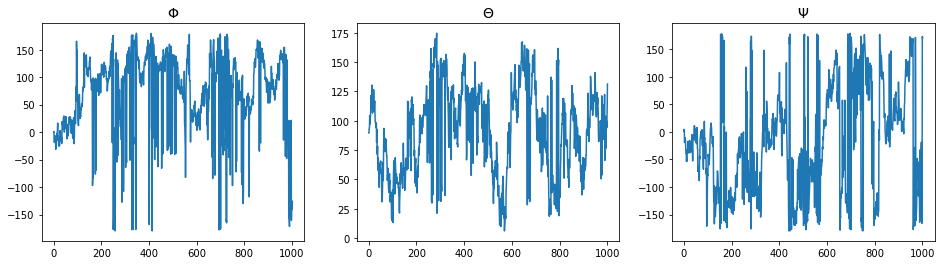

In [15]:
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.plot(euler_angles[:,0]*180/np.pi)
plt.title(r"$\Phi$", fontsize=14)
plt.subplot(132)
plt.plot(euler_angles[:,1]*180/np.pi)
plt.title(r"$\Theta$", fontsize=14)
plt.subplot(133)
plt.plot(euler_angles[:,2]*180/np.pi)
plt.title(r"$\Psi$", fontsize=14)